# What is funny 

This notebook discuss about :
- how funny is defined in this project : 
    - definition : Funny for most of the person that have seen it (remove pictures with no significance number of votes) (30min)
    - metric used to assess it (30min)
    - presentation of the funniest and worst caption, how they were found (1-2h)
- what type of caption are found funnier :
    - Are funny captions shorter? (df["caption"].str.len()) (1h)
    - More “?” or “!” in funny captions? (regex count) (1h)
    - do lexical diversity have fun effect : unexpected word (nltk, textstat) (2h)
    - Are funny captions more positive or negative? (2h)
    - Funnier captions are less semantically aligned with the image (more surprising) (CLIP (or BLIP) ou regarder ce que cyrielle elle a fait) (3h)
- what features most strongly predict humor? (random forest) - Features: sentiment, length, word embeddings, punctuation (4h)
- Funniest themes - word cloud (2h)

What is shown here is that : 
 % write results HERE (2-3h)
- most votes are to say it's unfunny, funny assesmsnt reprensent .. % of the votes --> it's quite rare to be perceived as funny
- distribution of mean : squared
- Average caption length, variance, number of words.

Visualiton to use : 
- distribution of humor score
- boxplots
- word cloud
- Scatterplot of image-caption similarity vs. funniness


idée pour politic : check if left and right are used

### Plannification of the work
estimated time ~20h 
finish result in next 4 weeks to have time to write result nicely -> 5h per week


## Data preparation

In [2]:
import pandas as pd
import numpy as n
import pickle
import re
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

"""
root = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
while root.parent != root:
    if ((root / ".git").exists() and 
        (root / "README.txt").exists() and 
        (root / "results.ipynb").exists()): break
    root = root.parent
if str(root) not in sys.path: sys.path.insert(0, str(root))

print("Root folder at: ", root)"""

# Detect root starting from this file or from notebook’s cwd
try:
    start_path = Path(__file__).resolve()
except NameError:
    start_path = Path.cwd()

root = start_path
while root != root.parent:
    # Check for any known project markers
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Sanity check — fallback if nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("⚠️ Project root not found — defaulting to current working directory")
    root = Path.cwd()

print(f"✅ Root folder detected at: {root}")

# Add project root to sys.path if not already
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

from src.utils.paths import *
from src.utils.general_utils import *

stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH
with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)


✅ Root folder detected at: /Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42


In [19]:
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']


In [28]:

dfs_with_id = [
    df.assign(source_id=i)   # ajoute une colonne avec l’indice du DF
    for i, df in enumerate(dataA)
]

# Concaténation des DataFrames
dataAm2 = pd.concat(dfs_with_id, ignore_index=True)

display(dataAm2)

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,original_index,source_id
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74,0,0
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78,1,0
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23,2,0
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19,3,0
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,1.52,4,0
...,...,...,...,...,...,...,...,...,...,...
2292673,Looks like we took a wrong turn at the Hubble ...,1.023256,0.016347,86,84,2,0,-8.46,4953,383
2292674,Post-modern just doesn't do it for me.,1.022222,0.015625,90,88,2,0,-8.57,4954,383
2292675,How was I supposed to know they covered themse...,1.020833,0.014654,96,94,2,0,-8.72,4955,383
2292676,"No, they wanted us to teleport the giveaway ca...",1.020619,0.020619,97,96,0,1,-8.84,4956,383


In [29]:
dataAm2.describe()

,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,original_index,source_id
count,2.292678e+06,2.292678e+06,2.292678e+06,2.292678e+06,2.292678e+06,2.292678e+06,2.292678e+06,2.292678e+06,2.292678e+06
mean,1.212950e+00,inf,1.269750e+02,9.192197e+01,2.492293e+01,1.012452e+01,-4.670872e+00,3.248243e+03,1.945607e+02
std,1.223762e-01,NaN,3.522038e+02,1.548743e+02,1.217136e+02,9.112131e+01,2.041439e+00,2.186955e+03,1.058515e+02
min,8.571429e-01,1.546432e-04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.755000e+01,0.000000e+00,0.000000e+00
25%,1.133333e+00,4.101020e-02,6.000000e+01,5.100000e+01,6.000000e+00,1.000000e+00,-5.930000e+00,1.493000e+03,1.050000e+02
50%,1.200000e+00,4.834570e-02,8.400000e+01,6.900000e+01,1.200000e+01,2.000000e+00,-5.010000e+00,2.997000e+03,2.020000e+02
75%,1.275676e+00,5.653322e-02,1.230000e+02,9.700000e+01,2.100000e+01,6.000000e+00,-3.820000e+00,4.617000e+03,2.790000e+02
max,2.998918e+00,inf,2.589100e+04,7.740000e+03,9.721000e+03,1.523200e+04,3.670000e+01,1.532800e+04,3.830000e+02


In [ ]:
#dataAm = pd.concat(dataA,ignore_index=False)
#dataAm = dataAm.reset_index().rename(columns={"index": "image_id"})

In [21]:
dataAm

,rank,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score
0,0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74
1,1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78
2,2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23
3,3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19
4,4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,1.52
...,...,...,...,...,...,...,...,...,...
2292673,4953,Looks like we took a wrong turn at the Hubble ...,1.023256,0.016347,86,84,2,0,-8.46
2292674,4954,Post-modern just doesn't do it for me.,1.022222,0.015625,90,88,2,0,-8.57
2292675,4955,How was I supposed to know they covered themse...,1.020833,0.014654,96,94,2,0,-8.72
2292676,4956,"No, they wanted us to teleport the giveaway ca...",1.020619,0.020619,97,96,0,1,-8.84


In [5]:
dataAm.sort_values("funny_score",ascending=False).head(5)

,rank,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score
862178,0,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,36.70
452628,0,Mission accomplished. We will report that this...,2.998918,0.001083,924,0,1,923,34.13
1041265,0,Looks like you're already familiar with the si...,2.387410,0.005740,14726,1941,5211,7574,30.64
1048528,0,I just want to make sure 'mousse' isn't a typo.,2.354409,0.006038,14266,2078,5048,7126,29.57
934245,0,Is the salmon fresh?,2.338348,0.005993,14423,2164,5232,7027,29.14


### 🎭 Construction of a New Funny Metric

To better identify which captions are truly funny, we designed a new *funny metric* that combines both the **proportion of votes** and the **popularity (number of votes)** of each caption.

#### 1. Weighted funny and unfunny ratios

We first compute the proportion of *funny* and *unfunny* votes relative to the total number of votes for each caption:

$$
\text{funny\_ratio} = \frac{N_{\text{funny}}}{N_{\text{total}}}
$$
$$
\text{unfunny\_ratio} = \frac{N_{\text{unfunny}}}{N_{\text{total}}}
$$

To give more importance to captions that received **more votes** (and are thus statistically more reliable), each ratio is weighted by the logarithm of the number of votes:

$$
\text{weighted\_funny} = \text{funny\_ratio} \times \log(1 + N_{\text{total}})
$$
$$
\text{weighted\_unfunny} = \text{unfunny\_ratio} \times \log(1 + N_{\text{total}})
$$

The logarithmic weighting ensures that captions with many votes are emphasized, while preventing those with extremely high vote counts from dominating the score.

#### 2. Standardization and combined score

We then normalize both weighted ratios using **z-scores** to make them comparable across captions:

$$
z_{\text{funny}} = \frac{\text{weighted\_funny} - \mu_{\text{funny}}}{\sigma_{\text{funny}}}
$$
$$
z_{\text{unfunny}} = \frac{\text{weighted\_unfunny} - \mu_{\text{unfunny}}}{\sigma_{\text{unfunny}}}
$$

Finally, the two standardized scores are combined into a **single composite score**:

$$
\text{combined\_score} = z_{\text{funny}} - z_{\text{unfunny}}
$$

A higher `combined_score` indicates captions that are **consistently rated funny** and **supported by a sufficient number of votes**.

#### 3. Ranking

All captions are then ranked according to this score:

$$
\text{rank\_funny} = \text{rank}(-\text{combined\_score})
$$

The highest `combined_score` (most funny) receives rank 1.


### Worst caption


### Funniest caption

According to this metric, ths funniest caption is between the 452628 and  

## What types of caption are funnier? 

### Random forest 
Target variable : 
- binary label (unfunny VS funny, determined based on the combined score values) 
- Conitnuaous score (Ranking)

Input variable : how do I defined good attributes ? 
- length
- num_exclamation
- nu

In [6]:
from textblob import TextBlob
import nltk
from collections import Counter
import re
from textblob import download_corpora
#run this in the terminal : python -m textblob.download_corpora 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
dataAm.head()

,rank,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score
0,0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74
1,1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78
2,2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23
3,3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19
4,4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,1.52


In [9]:
print(dataAm.shape)
2292678/2

(2292678, 9)


1146339.0

In [10]:
# run pendant longtemps 6minn <
results_blob = []
subset_test =dataAm.loc[1:1146339,]
subset_test.shape
for cap in subset_test['caption']:
    blob = TextBlob(cap)
    results_blob.append({
        'caption': cap,
        'tags': blob.tags,
        'words': blob.words,
        'num_words' : len(blob.words),
        'adjectives': [w for w, pos in blob.tags if pos.startswith("JJ")],
        'proper_nouns': [w for w, pos in blob.tags if pos == "NNP"],
        'num_proper_nouns' : len([w for w, pos in blob.tags if pos == "NNP"]),
        'num_verbs' : len([w for w, pos in blob.tags if pos.startswith("VB")]),
        'polarity': blob.sentiment.polarity, #sentiment entre -1 (négatif) et +1 (positif).
        'subjectivity': blob.sentiment.subjectivity, #Valeur entre 0 (objectif) et 1 (subjectif).
        'num_punct' : len(re.findall(r'[^\w\s]', cap)),
        'num_repeats' : len( re.findall(r'\b(\w+)\s+\1\b', cap.lower()))
        #'sentences': [str(s) for s in blob.sentences],
        #'nouns': blob.noun_phrases,
        #'verbs': [w.lower() for w, pos in blob.tags if pos.startswith("VB")],
        #'adverbs': [w for w, pos in blob.tags if pos.startswith("RB")],
        #'lemmas': [w.lemmatize() for w in blob.words], # pour comparer mot meme si pluriel
        #'word_counts': blob.word_counts,
        #'ngrams_2': blob.ngrams(2) # analyse mot ensemble
    })

# Convertir en DataFrame pour analyses
df_blob = pd.DataFrame(results_blob)

dataAm_t = subset_test.merge(df_blob, on="caption", how="left")
dataAm_t

KeyboardInterrupt: 

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

X = dataAm_t[['num_words',
        "polarity",
        "subjectivity",
        'num_proper_nouns',
        'num_verbs',
        'num_repeats',
        'num_punct' ]]  # tes features
y = dataAm_t["funny_score"]  # variable continue

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

model = DecisionTreeRegressor(max_depth=2, random_state=42)
model.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [20]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Prédictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Évaluer
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test) 

#interpretation :
#R² proche de 1 → modèle explique bien la variance
#R² négatif → le modèle est pire qu’une moyenne constante

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {r2_train:.3f}, RMSE: {rmse_train:.3f}")
print(f"Test R²: {r2_test:.3f}, RMSE: {rmse_test:.3f}")

Train R²: 0.019, RMSE: 1.950
Test R²: 0.020, RMSE: 1.964


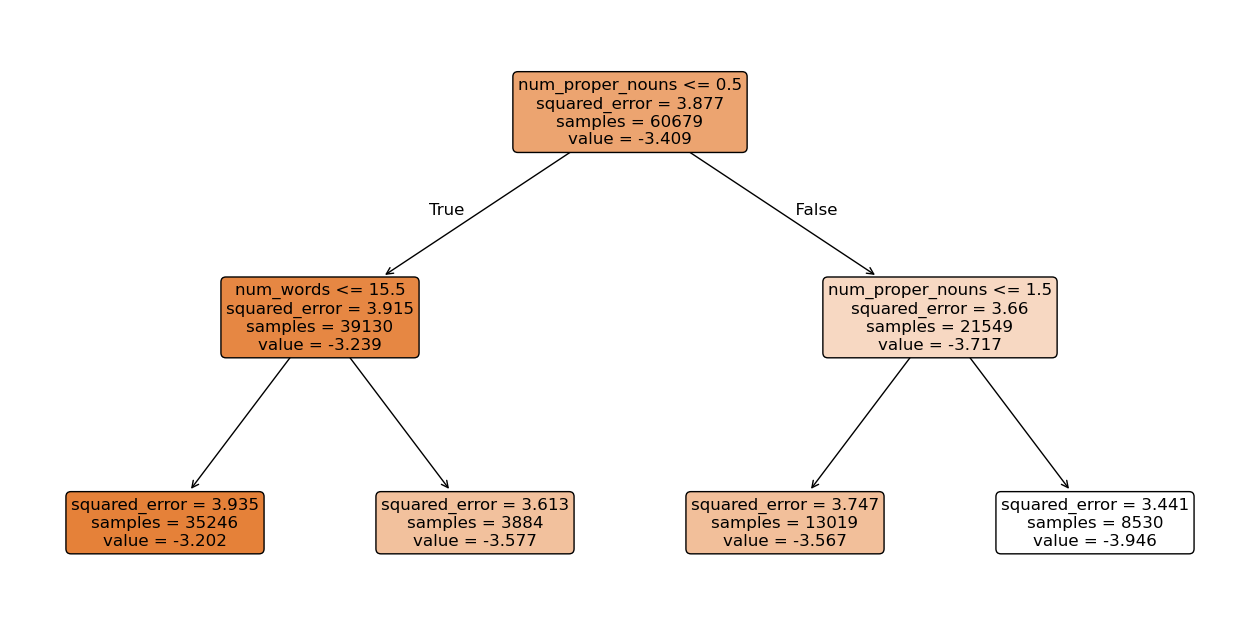

num_words: 0.112
polarity: 0.000
subjectivity: 0.000
num_proper_nouns: 0.888
num_verbs: 0.000
num_repeats: 0.000
num_punct: 0.000


In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plot_tree(model,
          feature_names=X_train.columns,
          filled=True,
          rounded=True,
          fontsize=12)
plt.show()

for f, imp in zip(X_train.columns, model.feature_importances_):
    print(f"{f}: {imp:.3f}")

# trop bizarre, si depth =2 alors subjectivité est masse importante, si depth =3 alors cest le nombre de noms propres et le nombre de mots

## Random Forest 
### 1. Prepare data

In [33]:
2292678/2


1146339.0

In [11]:
# run time of this cell : for half of the data it is 5min 47s
results_blob = []
subset_test_rf =dataAm.loc[1:1146339,] 
for cap in subset_test['caption']:
    blob = TextBlob(cap)
    results_blob.append({
        'caption': cap,
        'tags': blob.tags,
        'words': blob.words,
        'num_words' : len(blob.words),
        'adjectives': [w for w, pos in blob.tags if pos.startswith("JJ")],
        'proper_nouns': [w for w, pos in blob.tags if pos == "NNP"],
        'num_proper_nouns' : len([w for w, pos in blob.tags if pos == "NNP"]),
        'num_verbs' : len([w for w, pos in blob.tags if pos.startswith("VB")]),
        'polarity': blob.sentiment.polarity, #sentiment entre -1 (négatif) et +1 (positif).
        'subjectivity': blob.sentiment.subjectivity, #Valeur entre 0 (objectif) et 1 (subjectif).
        'num_punct' : len(re.findall(r'[^\w\s]', cap)),
        'num_repeats' : len( re.findall(r'\b(\w+)\s+\1\b', cap.lower()))
        #'sentences': [str(s) for s in blob.sentences],
        #'nouns': blob.noun_phrases,
        #'verbs': [w.lower() for w, pos in blob.tags if pos.startswith("VB")],
        #'adverbs': [w for w, pos in blob.tags if pos.startswith("RB")],
        #'lemmas': [w.lemmatize() for w in blob.words], # pour comparer mot meme si pluriel
        #'word_counts': blob.word_counts,
        #'ngrams_2': blob.ngrams(2) # analyse mot ensemble
    })

# Convertir en DataFrame pour analyses
df_blob = pd.DataFrame(results_blob)

dataAm_rf = subset_test_rf.merge(df_blob, on="caption", how="left")
dataAm_rf


,rank,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,tags,words,num_words,adjectives,proper_nouns,num_proper_nouns,num_verbs,polarity,subjectivity,num_punct,num_repeats
0,1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78,"[(I, PRP), ('m, VBP), (what, WP), (they, PRP),...","[I, 'm, what, they, mean, when, they, say, 'Th...",15,[middle],[],0,6,-0.156250,0.343750,5,0
1,2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23,"[(Does, VBZ), (this, DT), (suit, NN), (make, V...","[Does, this, suit, make, me, look, flat]",7,[flat],[],0,3,-0.025000,0.125000,1,0
2,3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19,"[(When, WRB), (the, DT), (right, JJ), (woman, ...","[When, the, right, woman, comes, along, I, 'll...",10,[right],[],0,2,0.285714,0.535714,3,0
3,4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,1.52,"[(I, PRP), (used, VBD), (to, TO), (lie, VB), (...","[I, used, to, lie, in, the, gutter, but, then,...",12,[],[],0,4,0.000000,0.000000,2,0
4,5,"If you can meditate here, you can meditate any...",1.617647,0.126764,34,18,11,5,1.73,"[(If, IN), (you, PRP), (can, MD), (meditate, V...","[If, you, can, meditate, here, you, can, medit...",9,[],[],0,2,0.000000,0.000000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265586,1422,Are they always so territorial?,1.250000,0.046215,120,94,22,4,-4.52,"[(Are, IN), (they, PRP), (always, RB), (so, RB...","[Are, they, always, so, territorial]",5,[territorial],[],0,0,0.000000,0.000000,1,0
1265587,1423,Are you sure we’re on mute?,1.250000,0.047707,120,95,20,5,-4.60,"[(Are, NNP), (you, PRP), (sure, VBP), (we, PRP...","[Are, you, sure, we, ’, re, on, mute]",8,[],[Are],1,3,0.500000,0.888889,2,0
1265588,1424,"Remember, whichever way he falls, that’s who g...",1.250000,0.044674,120,93,24,3,-4.44,"[(Remember, NNP), (whichever, WDT), (way, NN),...","[Remember, whichever, way, he, falls, that, ’,...",13,[’],[Remember],1,3,0.000000,0.000000,4,0
1265589,1425,Quarantine Day 122: what else can we do to pla...,1.250000,0.047707,120,95,20,5,-4.60,"[(Quarantine, NNP), (Day, NNP), (122, CD), (wh...","[Quarantine, Day, 122, what, else, can, we, do...",14,[],"[Quarantine, Day, Boots]",3,2,0.000000,0.000000,3,0


,rank,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,tags,words,num_words,adjectives,proper_nouns,num_proper_nouns,num_verbs,polarity,subjectivity,num_punct,num_repeats
66319,490,So....what type of business did you say you we...,1.388235,0.069197,85,59,19,7,-1.86,"[(So, RB), (...., VB), (what, WP), (type, NN),...","[So, what, type, of, business, did, you, say, ...",172,"[least, more, little, intense, new, much, long...","[Well, Planet, Apes, Planet, Apes, BluRay, Sha...",15,31,0.174697,0.501837,62,0
67747,1883,They just finished downloading everything Shak...,1.230769,0.075783,52,43,6,3,-4.28,"[(They, PRP), (just, RB), (finished, VBD), (do...","[They, just, finished, downloading, everything...",243,"[more, sorry, right, much, mine, urban, least,...","[Shakespeare, Monroe, County, Movers, Monkey, ...",14,51,0.164286,0.330075,105,0
68016,2122,Monkeys don't breed well in captivity...yea ri...,1.212121,0.059191,66,54,10,2,-4.65,"[(Monkeys, NNS), (do, VBP), (n't, RB), (breed,...","[Monkeys, do, n't, breed, well, in, captivity,...",454,"[more, fun, wrong, sure, d, ‘, catchier, last,...","[Planet, Apes, ’, Pre-typing, Costco, Wrong, B...",40,92,0.157351,0.353532,219,0
68403,2497,Why couldn't it be a barrel of chocolates? Or ...,1.187500,0.064249,48,40,7,1,-4.66,"[(Why, WRB), (could, MD), (n't, RB), (it, PRP)...","[Why, could, n't, it, be, a, barrel, of, choco...",380,"[monkey, eleven, open, least, better, more, ha...","[Chippendale, Swingers, Just, 'widdle, Let, Br...",19,80,0.092873,0.319540,186,0
69316,3336,I warned you that no good would come of tellin...,1.120000,0.046423,50,44,6,0,-5.74,"[(I, PRP), (warned, VBD), (you, PRP), (that, I...","[I, warned, you, that, no, good, would, come, ...",244,"[good, least, rid, more, military, sure, empty...","[Clarence, Darrow, Donkeys, IN, Honey, Go, NFL...",11,51,0.152352,0.412812,115,0
69836,3851,I TOLD you they'd take after your side of the ...,1.062500,0.043476,32,30,2,0,-6.01,"[(I, PRP), (TOLD, VBP), (you, PRP), (they, PRP...","[I, TOLD, you, they, 'd, take, after, your, si...",181,"[Emotional, monkey, good, hard, original, much]","[Banana, Support, Animals, Amazon, Did, Invita...",6,41,0.066601,0.420503,75,0
70042,4055,I told you if you didn't get ECHO out of the B...,1.032258,0.032791,31,30,1,0,-6.43,"[(I, PRP), (told, VBD), (you, PRP), (if, IN), ...","[I, told, you, if, you, did, n't, get, ECHO, o...",235,"[more, uncle, monkey, barrel, new, other, luck...","[ECHO, BEDROOM, Golden, Retriever, Family, Pac...",23,44,0.063344,0.317252,102,0
1240122,4275,Red Sam came in and told his wife to quit loun...,1.206349,0.068480,63,54,5,4,-4.98,"[(Red, JJ), (Sam, NNP), (came, VBD), (in, IN),...","[Red, Sam, came, in, and, told, his, wife, to,...",115,"[Red, s, t, t, red, gray, ’]","[Sam, Ain, ’]",3,18,0.288889,0.217778,23,0
1264670,525,"I began to feel resigned to my fate, and as I ...",1.333333,0.042651,204,151,38,15,-3.44,"[(I, PRP), (began, VBD), (to, TO), (feel, VB),...","[I, began, to, feel, resigned, to, my, fate, a...",106,"[same, clear, firm, last]",[God],1,25,-0.020000,0.195000,9,0


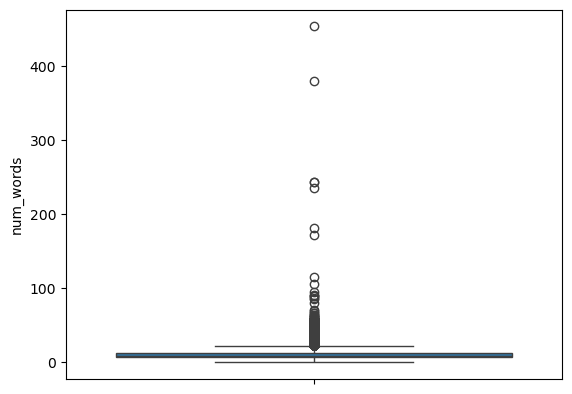

In [16]:
sns.boxplot(dataAm_rf["num_words"])
dataAm_rf[dataAm_rf["num_words"]>=100]
#dataAm_rf.iloc[66319]["caption"]

### 2. Assigne X and y, prepare datasets

In [35]:
X = dataAm_rf[['num_words',
        "polarity",
        "subjectivity",
        'num_proper_nouns',
        'num_verbs',
        'num_repeats',
         'num_punct' ]]  # tes features
y = dataAm_rf["funny_score"]  # variable continue

# Split 80/20
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split trainval en train et validation
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42
)

### 3. Find best model 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
results = []

for depth in [ 2, 4, 8]:
    for n in [50, 100]:
        model = RandomForestRegressor(
            max_depth=depth,
            n_estimators=n,
            random_state=42
        )

        model.fit(X_train, y_train)

        # score sur validation
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)

        results.append((depth, n, mse))

results

[(2, 50, 4.322811287978574),
 (2, 200, 4.322605339483626),
 (4, 50, 4.300819357647176),
 (4, 200, 4.301650514165864),
 (6, 50, 4.22447634216612)]

In [39]:
best = min(results, key=lambda x: x[2])
best

(8, 200, 4.203098629850323)

### 4. Run model 

In [40]:
best_model = RandomForestRegressor(
    max_depth=best[0],
    n_estimators=best[1],
    random_state=42
)

best_model.fit(X_trainval, y_trainval)

y_test_pred = best_model.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
mse_test

4.167786927044108

In [ ]:
print("R² :", r2_score(y_test, y_test_pred)) # faire mean sqaure error  ou mean absolute error


R² : 0.03196953843091965


MSE : 4.260118922834834
R² : 0.010524060034958982


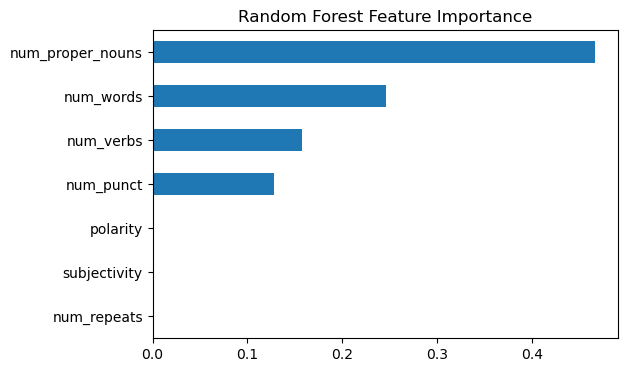

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

rf = RandomForestRegressor(
    n_estimators=200,      # nombre d’arbres
    max_depth=4,           # profondeur des arbres (pour éviter l’overfitting)
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("MSE :", mean_squared_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
#feature_importances.sort_values(ascending=False)

feature_importances.sort_values().plot(kind="barh", figsize=(6,4))
plt.title("Random Forest Feature Importance")
plt.show()

### PCA 
- Standardize data
- 
etape d'apres : 
- faire model ols ? weigthed ? 
- separate data in training data? 

# Proposed Second Results.ipynb

## Axis 1: What Is Considered Funny
- **Presentation of the funniest and worst captions**, including the method used to identify them (1–2h)
- **Characteristics of funnier captions:**
    - Are funnier captions shorter? (`df["caption"].str.len()`) (1h)
    - Do they contain more punctuation like `?` or `!`? (Regex count) (1h)
    - Does lexical diversity influence humor? (Unexpected words, using `nltk`, `textstat`) (2h)
    - Are funnier captions more positive or negative? (Sentiment analysis) (2h)
    - Are funnier captions less semantically aligned with the image (more surprising)? (Using CLIP or BLIP, or building on Cyrielle’s work) (3h)
- **Predictive analysis:** Which features best predict humor? (Random Forest)  
  *Features: sentiment, length, word embeddings, punctuation* (4h)
- **Funniest themes:** Word cloud visualization (2h)

## Axis 2: Professions, Politics, and Power
- Explore how humor relates to professions, political context, and power dynamics.

## Axis 3: Gender Roles
- Analyze the influence of gender stereotypes and roles on perceived humor.

## Axis 4: TBD
- To be determined based on further data exploration.

## Conclusion
- Summarize insights on humor, social context, and the factors that make captions funny.

### 4.1. Axis 1: What Is Considered Funny

The first thing done was to check how funny score were distributed. From the figure under, whcih summed all the votes for each category aver all cartton, it is clear that the distribution is skewed and that the mean can be heavely impacted. To conter this a new metric was created (see mathematical specification in point 1.2) which allow to better grasp funnynest at our sense. To show the performance of htis metrics, the head and the tail  captions over he all dataset are sorted here according to first by their mean and the by the funny_score. 

In [ ]:
# Load table
df_results = pd.read_csv("../results/funny_score_summary.csv")

# Load figure (for display)
from IPython.display import Image, display
display(Image(filename="../figures/funny_score_distribution.png"))


# P2 backup : 

In [ ]:
# Data merging to assess all captions together

for i, df in enumerate(dataA):
    df['source_df'] = i  # i  allow to keep the informatio of which images the caption is related to

dataA_merged = pd.concat(dataA, ignore_index=True)

from src.utils.function_axis_1 import plot_global_vote_distribution
plot_global_vote_distribution(dataA_merged)



The first step was to examine how the funny scores were distributed. From the figure below, which sums all votes for each category across all captions, we can clearly see that the number of votes for not_funny is much higher than for the other categories. This skewed distribution means that computing the mean would be biased toward 1. To address this, a new metric for funniness was developed (see the mathematical specification in Section 1.2), which is more resilient to the high number of negative votes. With this metric, we focus solely on what people find genuinely funny, without taking into account the "somewhat funny" votes. To demonstrate the effectiveness of this metric, the top captions across the dataset are presented, first sorted by their mean and then by the new funny_score.

In [ ]:
from src.utils.function_axis_1 import compute_funny_ranking
from IPython.display import display, Markdown

dataA_merged = compute_funny_ranking(dataA_merged)

Mean_best = dataA_merged.sort_values(["mean"],ascending=False).head(5)
display(Markdown("### Top 5 Captions by Mean Score"))
display(Mean_best)

Funny_score_best = dataA_merged.sort_values(["funny_score"],ascending=False).head(5)
display(Markdown("### Top 5 Captions by Funny Score"))
display(Funny_score_best)


From the top captions above, we can see that the new metric changes the ranking and provides a more intuitive order. For example, the second caption becomes "Lunch on me," which received 15,232 funny votes but had a lower mean than other captions with fewer voters. This shows that the new metric better accounts for the funninness of the caption.

Similarly, for the lowest-ranked captions, our metric outperforms the mean. Using the mean, all poorly rated captions received a score of 1, which did not distinguish the very worst captions from the rest. With the new metric, captions with more votes carry greater weight, so the lowest-ranked captions are those that were overwhelmingly voted as not funny.

### 4.1. Axis 1: What Is Considered Funny

The first step was to examine how the funny scores were distributed. From the figure below, which sums all votes for each category across all captions, we can clearly see that the number of votes for not_funny is much higher than for the other categories. This skewed distribution means that computing the mean would be biased toward 1. To address this, a new metric for funniness was developed (see the mathematical specification in Section 1.2), which is more resilient to the high number of negative votes. With this metric, we focus solely on what people find genuinely funny, without taking into account the "somewhat funny" votes. To demonstrate the effectiveness of this metric, the top captions across the dataset are presented, first sorted by their mean and then by the new funny_score.

In [ ]:
from src.utils.function_axis_1 import plot_global_vote_distribution
from src.utils.function_axis_1 import compute_funny_ranking
from IPython.display import display, Markdown
for i, df in enumerate(dataA):
    df['source_df'] = i  # i  allow to keep the informatio of which images the caption is related to

dataA_merged = pd.concat(dataA, ignore_index=True) # Data merging to assess all captions together


plot_global_vote_distribution(dataA_merged)

dataA_merged = compute_funny_ranking(dataA_merged)

Mean_best = dataA_merged.sort_values(["mean"],ascending=False).head(5)
display(Markdown("### Top 5 Captions by Mean Score"))
display(Mean_best)

Funny_score_best = dataA_merged.sort_values(["funny_score"],ascending=False).head(5)
display(Markdown("### Top 5 Captions by Funny Score"))
display(Funny_score_best)

Funny_score_worst = dataA_merged.sort_values(["funny_score"],ascending=True).head(5)
display(Markdown("### Last 5 Captions by Funny Score"))
display(Funny_score_worst)


From the top captions above, we can see that the new metric reshuffles the ranking to provide a more intuitive order. For instance, the second caption becomes "Lunch on me," which received 15,232 funny votes but had a lower mean than other captions with fewer voters. This demonstrates that the new metric better reflects the true funniness of each caption.

Similarly, for the lowest-ranked captions, our metric outperforms the mean. Using the mean, all poorly rated captions scored 1, failing to distinguish the very worst captions from the rest. With the new metric, captions with more votes carry greater weight, so the lowest-ranked captions are those that were overwhelmingly voted as not funny, as shown in the final DataFrame above.